In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
maotai = pd.read_csv("./SH600519.csv")

In [24]:
train_set = maotai.iloc[0:2425-300,2:3].values
test_set = maotai.iloc[2425-300:, 2:3].values

In [25]:
train_set

array([[5.726],
       [5.785],
       [5.823],
       ...,
       [2.56 ],
       [2.54 ],
       [2.6  ]])

In [26]:
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.transform(test_set)

In [36]:
x_train, y_train = [],[]
x_test, y_test = [],[]
for i in range(60, len(train_set_scaled)):
    x_train.append(train_set_scaled[i-60:i, 0])
    y_train.append(train_set_scaled[i,0])

In [37]:
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

In [38]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1))

In [39]:
for i in range(60,len(test_set_scaled)):
    x_test.append(test_set_scaled[i-60:i,0])
    y_test.append(test_set_scaled[i, 0])

In [40]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

In [41]:
model = tf.keras.models.Sequential([
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss = 'mean_squared_error')

model_save_path = 'maotai_LSTM_checkpoint/LSTM_stock.ckpt'
if os.path.exists(model_save_path+'.index'):
    print("----------------load model-----------------")
    model.load_weights(model_save_path)
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                   callbacks=[cp_callback])

model.summary()

Epoch 1/50
65/65 [==============================] - 6s 46ms/step - loss: 0.0120 - val_loss: 2.0243e-04
Epoch 2/50
65/65 [==============================] - 2s 30ms/step - loss: 0.0019 - val_loss: 2.0016e-04
Epoch 3/50
65/65 [==============================] - 2s 35ms/step - loss: 0.0014 - val_loss: 2.4195e-04
Epoch 4/50
65/65 [==============================] - 2s 35ms/step - loss: 0.0011 - val_loss: 1.8764e-04
Epoch 5/50
65/65 [==============================] - 2s 35ms/step - loss: 0.0016 - val_loss: 1.7482e-04
Epoch 6/50
65/65 [==============================] - 2s 35ms/step - loss: 9.8611e-04 - val_loss: 2.2532e-04
Epoch 7/50
65/65 [==============================] - 2s 35ms/step - loss: 0.0011 - val_loss: 1.3891e-04
Epoch 8/50
65/65 [==============================] - 2s 35ms/step - loss: 9.6206e-04 - val_loss: 1.5041e-04
Epoch 9/50
65/65 [==============================] - 2s 35ms/step - loss: 0.0010 - val_loss: 1.5522e-04
Epoch 10/50
65/65 [==============================] - 2s 34ms/step

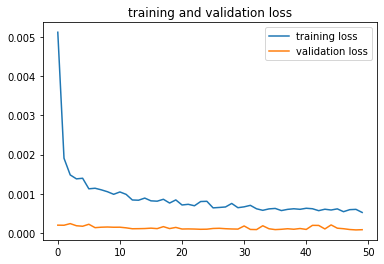

In [42]:
with open("./lstm_maotai_weights.txt", 'w') as f:
    for v in model.trainable_variables:
        f.write(str(v.name)+'\n')
        f.write(str(v.shape)+'\n')
        f.write(str(v.numpy())+'\n')
        
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title("training and validation loss")
plt.legend()
plt.show()

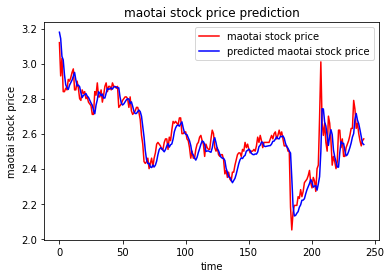

In [46]:
predicted_stock_price = model.predict(x_test)
predicted = sc.inverse_transform(predicted_stock_price)
real_price = sc.inverse_transform(test_set_scaled[60:])

plt.plot(real_price, color = 'red', label='maotai stock price')
plt.plot(predicted, color='blue', label='predicted maotai stock price')
plt.title('maotai stock price prediction')
plt.xlabel('time')
plt.ylabel('maotai stock price')
plt.legend()
plt.show()

In [47]:
mse = mean_squared_error(predicted, real_price)
rmse = math.sqrt(mse)
mae = mean_absolute_error(predicted, real_price)
print(mse)
print(rmse)
print(mae)

0.005709544931779635
0.07556153076651925
0.05044126506679313
